In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hate-speech-and-offensive-language-detection/train.csv


In [2]:
import numpy as np
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dropout, Dense
from tensorflow.keras.metrics import Precision, Recall, AUC

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [5]:
df = pd.read_csv('/kaggle/input/hate-speech-and-offensive-language-detection/train.csv')


In [6]:
# Add NLTK stopwords and download if necessary
nltk.download('stopwords')
nltk.download('punkt')

# Function to preprocess the tweets
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    text = text.replace('\n', ' ').replace('\t', ' ')
    text = re.sub(' +', ' ', text)
    text = text.replace('"', '').replace("'s", "")
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Apply the preprocessing function to the 'tweet' column
df['tweet'] = df['tweet'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
# Define features and labels
X = df['tweet']
y = df['class']

# Display unique labels and their counts
y.value_counts()

class
1    19190
2     4163
0     1430
Name: count, dtype: int64

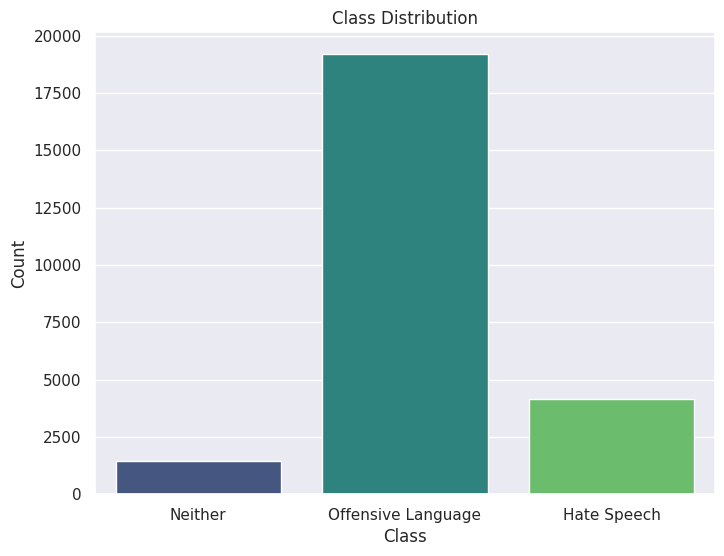

In [8]:
# Set the style for seaborn
sns.set(style="darkgrid")

# Plot the class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=y, palette="viridis")
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2], labels=['Neither', 'Offensive Language', 'Hate Speech'])
plt.show()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


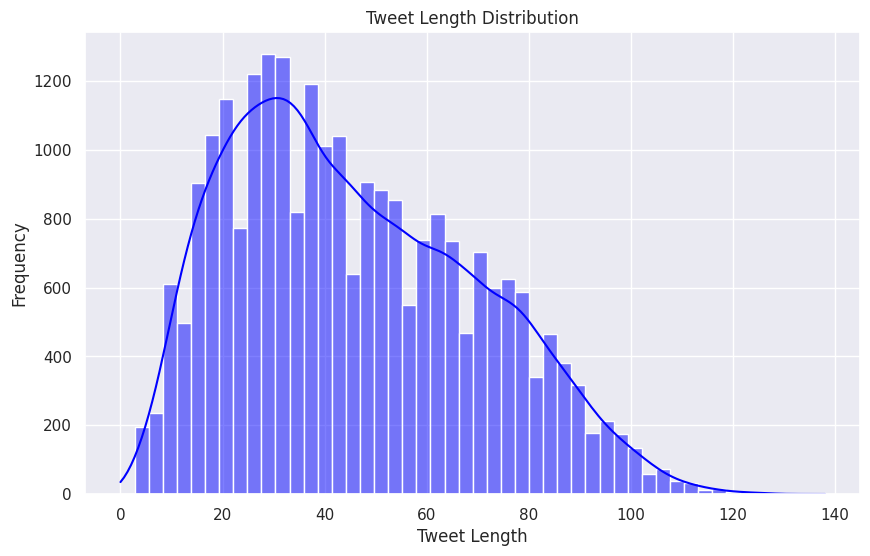

In [9]:
# Calculate the length of each tweet
tweet_lengths = df['tweet'].apply(len)

# Plot the tweet length distribution
plt.figure(figsize=(10, 6))
sns.histplot(tweet_lengths, bins=50, kde=True, color='blue')
plt.title('Tweet Length Distribution')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.show()


In [10]:


# Preprocess the tweets as described earlier
df['processed_tweet'] = df['tweet'].apply(preprocess_text)

# Combine all tweets for each class into a single string
neither_text = ' '.join(df[df['class'] == 0]['processed_tweet'])
offensive_text = ' '.join(df[df['class'] == 1]['processed_tweet'])
hate_speech_text = ' '.join(df[df['class'] == 2]['processed_tweet'])

# Print the first 100 words for each class
print("Neither (first 100 words):\n", ' '.join(neither_text.split()[:100]))
print("\nOffensive Language (first 100 words):\n", ' '.join(offensive_text.split()[:100]))
print("\nHate Speech (first 100 words):\n", ' '.join(hate_speech_text.split()[:100]))


Neither (first 100 words):
 queer gaywad alsarabsss hes beaner smh tell hes mexican youre fucking gay blacklisted hoe holding tehgodclan anyway lmfaoooo hate black people theres black people niggers least im nigger lmfao ariza snake coward least isnt cripple like hero roach lmaoo drakes new shoes released nikejordan yes theres glitter shoes dudes fag gerryshalloweenparty halloween yesterday stupid nigger bored supposed cute faggot sometimes lassen cc coach wants feel youll get nig doubt jackies retard blondeproblems least make grilled cheese stacey dash baddest bitch evaaaa dont worry nigga see worry nigga dont see dats da nigga fuckin yo bitch hey go look video man

Offensive Language (first 100 words):
 rt boy dats coldtyga dwn bad cuffin dat hoe st place rt dawg rt ever fuck bitch start cry confused shit rt look like tranny rt shit hear might true might faker bitch told ya shit blows meclaim faithful somebody still fucking hoes sit hate another bitch got much shit going cause im tir

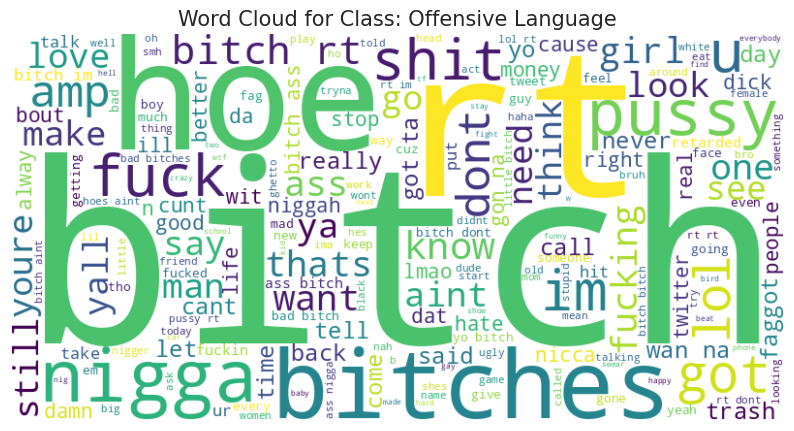

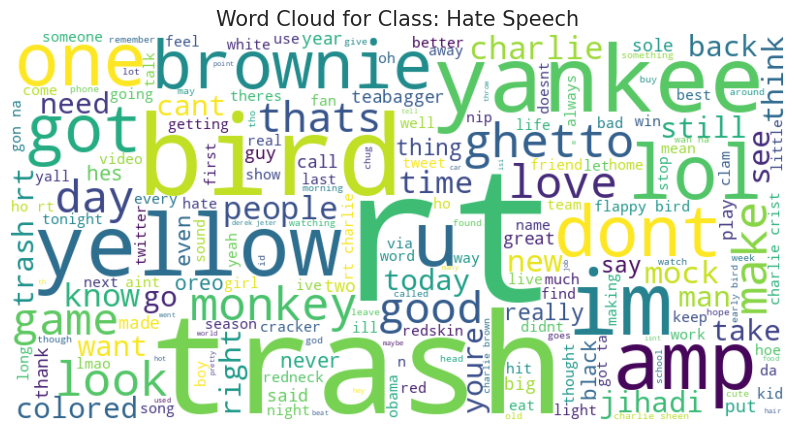

In [12]:
from wordcloud import WordCloud

# Function to generate and display a word cloud
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=15)
    plt.axis('off')
    plt.show()

# Combine all tweets for each class into a single string
offensive_text = ' '.join(df[df['class'] == 1]['processed_tweet'])
hate_speech_text = ' '.join(df[df['class'] == 2]['processed_tweet'])

# Generate word clouds
generate_wordcloud(offensive_text, 'Word Cloud for Class: Offensive Language')
generate_wordcloud(hate_speech_text, 'Word Cloud for Class: Hate Speech')


In [14]:
# Split the data
X = df['tweet'].values
y = df['class'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# Get the vocabulary size
vocab_size = len(tokenizer.word_index) + 1

# Padding
max_length = max(len(seq) for seq in X_train)
X_train = pad_sequences(X_train, maxlen=max_length)
X_test = pad_sequences(X_test, maxlen=max_length)

# Convert labels to categorical
y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

In [15]:
output_dim = 200

# LSTM

In [ ]:
# Standalone LSTM model architecture
model_lstm = Sequential([
    Embedding(vocab_size, output_dim, input_length=max_length),
    LSTM(64, dropout=0.3, recurrent_dropout=0.3),
    Dropout(0.5),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(3, activation="softmax"),
])

model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall(), AUC()])
# Display the model summary
model_lstm.summary()
# Train the standalone LSTM model
model_lstm.fit(X_train, y_train, batch_size=64, epochs=10, validation_data=(X_test, y_test))

# Evaluate the standalone LSTM model
y_pred_lstm = model_lstm.predict(X_test)
y_pred_classes_lstm = np.argmax(y_pred_lstm, axis=1)
y_true = np.argmax(y_test, axis=1)

# Generate classification report for LSTM model
report_lstm = classification_report(y_true, y_pred_classes_lstm, target_names=['Neither', 'Offensive Language', 'Hate Speech'])
print("LSTM Model Classification Report:\n", report_lstm)


# GRU

In [27]:
# Standalone GRU model architecture
model_gru = Sequential([
    Embedding(vocab_size, output_dim, input_length=max_length),
    GRU(64, dropout=0.3, recurrent_dropout=0.3),
    Dropout(0.5),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(3, activation="softmax"),
])

model_gru.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall(), AUC()])
model_gru.summary()

# Train the standalone GRU model
model_gru.fit(X_train, y_train, batch_size=64, epochs=10, validation_data=(X_test, y_test))

# Evaluate the standalone GRU model
y_pred_gru = model_gru.predict(X_test)
y_pred_classes_gru = np.argmax(y_pred_gru, axis=1)
y_true = np.argmax(y_test, axis=1)

# Generate classification report for GRU model
report_gru = classification_report(y_true, y_pred_classes_gru, target_names=['Neither', 'Offensive Language', 'Hate Speech'])
print("GRU Model Classification Report:\n", report_gru)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 29, 200)           3803000   
                                                                 
 gru_1 (GRU)                 (None, 64)                51072     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 3)                 387       
                                                                 
Total params: 3862779 (14.74 MB)
Trainable params: 386

# Hybrid LSTM-GRU model architecture

In [28]:
# Hybrid LSTM-GRU model architecture
model_hybrid = Sequential([
    Embedding(vocab_size, output_dim, input_length=max_length),
    LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.3),
    GRU(64, dropout=0.3, recurrent_dropout=0.3),
    Dropout(0.5),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(3, activation="softmax"),
])

model_hybrid.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall(), AUC()])

# Train the hybrid LSTM-GRU model
model_hybrid.fit(X_train, y_train, batch_size=64, epochs=10, validation_data=(X_test, y_test))

# Evaluate the hybrid LSTM-GRU model
y_pred_hybrid = model_hybrid.predict(X_test)
y_pred_classes_hybrid = np.argmax(y_pred_hybrid, axis=1)
y_true = np.argmax(y_test, axis=1)

# Generate classification report for hybrid LSTM-GRU model
report_hybrid = classification_report(y_true, y_pred_classes_hybrid, target_names=['Neither', 'Offensive Language', 'Hate Speech'])
print("Hybrid LSTM-GRU Model Classification Report:\n", report_hybrid)


Epoch 1/10
310/310 [==============================] - 80s 237ms/step - loss: 0.4649 - accuracy: 0.8414 - precision_3: 0.8691 - recall_3: 0.7926 - auc_3: 0.9437 - val_loss: 0.3239 - val_accuracy: 0.8862 - val_precision_3: 0.9000 - val_recall_3: 0.8747 - val_auc_3: 0.9696
Epoch 2/10
310/310 [==============================] - 62s 201ms/step - loss: 0.2468 - accuracy: 0.9181 - precision_3: 0.9298 - recall_3: 0.9067 - auc_3: 0.9812 - val_loss: 0.3147 - val_accuracy: 0.8844 - val_precision_3: 0.8930 - val_recall_3: 0.8739 - val_auc_3: 0.9728
Epoch 3/10
310/310 [==============================] - 60s 192ms/step - loss: 0.1644 - accuracy: 0.9436 - precision_3: 0.9481 - recall_3: 0.9387 - auc_3: 0.9911 - val_loss: 0.3813 - val_accuracy: 0.8848 - val_precision_3: 0.8896 - val_recall_3: 0.8812 - val_auc_3: 0.9650
Epoch 4/10
310/310 [==============================] - 61s 195ms/step - loss: 0.1109 - accuracy: 0.9607 - precision_3: 0.9629 - recall_3: 0.9582 - auc_3: 0.9956 - val_loss: 0.4596 - val_ac

# Comparison

LSTM Model Classification Report:
                     precision    recall  f1-score   support

           Neither       0.31      0.23      0.27       286
Offensive Language       0.90      0.93      0.92      3838
       Hate Speech       0.81      0.74      0.78       833

          accuracy                           0.86      4957
         macro avg       0.68      0.64      0.65      4957
      weighted avg       0.85      0.86      0.86      4957

GRU Model Classification Report:
                     precision    recall  f1-score   support

           Neither       0.33      0.27      0.30       286
Offensive Language       0.90      0.94      0.92      3838
       Hate Speech       0.84      0.73      0.78       833

          accuracy                           0.86      4957
         macro avg       0.69      0.64      0.66      4957
      weighted avg       0.86      0.86      0.86      4957

Hybrid LSTM-GRU Model Classification Report:
                     precision    recall

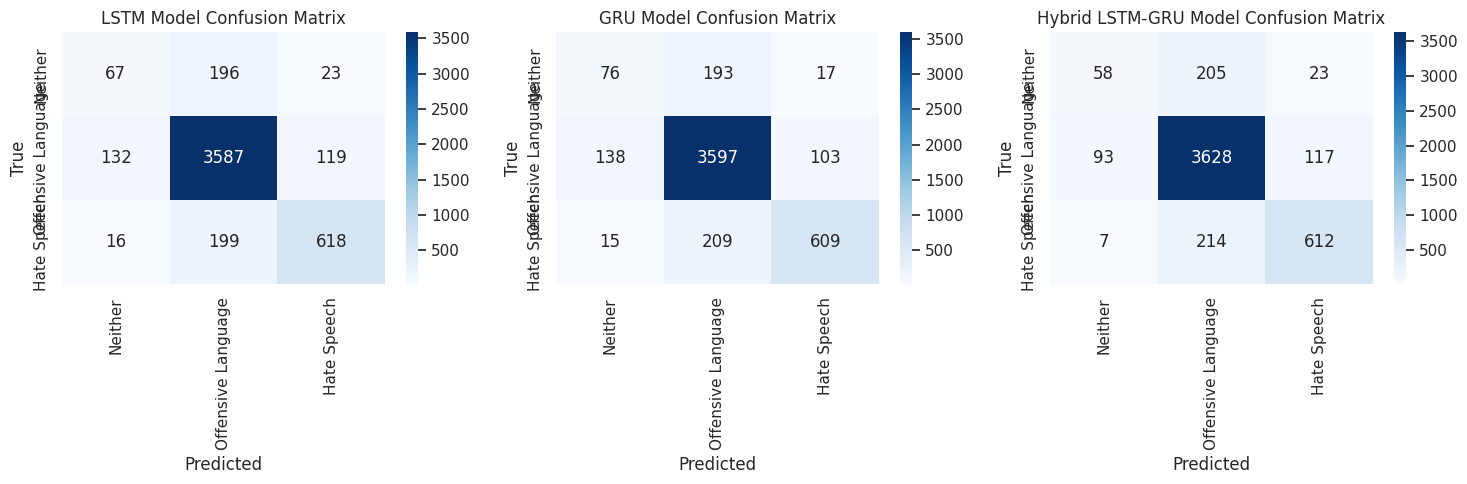

In [30]:
from sklearn.metrics import confusion_matrix, classification_report
print("LSTM Model Classification Report:\n", report_lstm)
print("GRU Model Classification Report:\n", report_gru)
print("Hybrid LSTM-GRU Model Classification Report:\n", report_hybrid)

# Confusion matrices for all three models
conf_matrix_lstm = confusion_matrix(y_true, y_pred_classes_lstm)
conf_matrix_gru = confusion_matrix(y_true, y_pred_classes_gru)
conf_matrix_hybrid = confusion_matrix(y_true, y_pred_classes_hybrid)

# Plot confusion matrices
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.heatmap(conf_matrix_lstm, annot=True, fmt='d', cmap='Blues', xticklabels=['Neither', 'Offensive Language', 'Hate Speech'], yticklabels=['Neither', 'Offensive Language', 'Hate Speech'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('LSTM Model Confusion Matrix')

plt.subplot(1, 3, 2)
sns.heatmap(conf_matrix_gru, annot=True, fmt='d', cmap='Blues', xticklabels=['Neither', 'Offensive Language', 'Hate Speech'], yticklabels=['Neither', 'Offensive Language', 'Hate Speech'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('GRU Model Confusion Matrix')

plt.subplot(1, 3, 3)
sns.heatmap(conf_matrix_hybrid, annot=True, fmt='d', cmap='Blues', xticklabels=['Neither', 'Offensive Language', 'Hate Speech'], yticklabels=['Neither', 'Offensive Language', 'Hate Speech'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Hybrid LSTM-GRU Model Confusion Matrix')

plt.tight_layout()
plt.show()
